[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana11/Work2vec_BERT.ipynb)

# Introducción:

##Comando auxiliares

- Para instalación normal

  - !pip install [nombre_paquete]

- Actualizar

  - !pip install [nombre_paquete] --upgrade

- Forzar el reinstalado
  - !pip install --force-reinstall [nombre_paquete]

- Instalar utilizando APT
  - !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2



In [1]:
# !pip install --force-reinstall tensorflow
# ==2.8

In [2]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 36.1 MB/s 
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 5.8 MB 59.2 MB/s 
     |████████████████████████████████| 438 kB 71.9 MB/s 
     |████████████████████████████████| 1.6 MB 59.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [3]:
!pip install bert-for-tf2
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 154 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=4e11f4fb7519aba1a679564c669984fed7a91c3dd21c2ce13184fc88c663f7ca
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=d5df6a5c9c15333c895243f8233e05e5a78fe1dfe62e9de402ee62ec872e1a28
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=0962ab0e2fad0862e5ea0eb1e2b31c58d7dad9d408174f642291b64a89c84111
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [4]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 9s (49.6 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

IMPORTANTE: En caso de que no funcione su colab, probablemente tengan que descomentar el cuadro de código donde se fuerza la reinstalación de twnsorflow (primer cuadro de código, que se encuentra comentado)

# Dependencias

In [5]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
import bert

import re

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga y exploración de datos

In [7]:
reviews = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana11/DataAnalyst.csv', encoding='utf-8')

In [8]:
reviews

,Index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,TRUE
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,257,Data Analyst - QC,$73K-$127K (Glassdoor est.),Nesco Resource is seeking a Data Analyst for a...,2.9,"Nesco Resource, LLC\n2.9","New York, NY",1001 to 5000 employees,Company - Private,Staffing & Outsourcing,Business Services,$500 million to $1 billion (USD),-1,-1
258,258,People Operations & Data Analyst,$73K-$127K (Glassdoor est.),JOB DESCRIPTION:\n\nMuseum of Ice Cream is see...,2.3,Museum of Ice Cream\n2.3,"New York, NY",201 to 500 employees,Company - Private,-1,-1,Unknown / Non-Applicable,-1,-1
259,259,Lead Data Analyst (Product),$73K-$127K (Glassdoor est.),A BIT ABOUT OUR DATA & ANALYTICS TEAM\n\nThe K...,-1.0,Kinship,"New York, NY",1 to 50 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,-1,-1
260,260,Data Analyst - III,$73K-$127K (Glassdoor est.),Direct Client Requirement\nPosition: Data Anal...,4.2,APN Consulting\n4.2,"New York, NY",1 to 50 employees,Company - Private,Advertising & Marketing,Business Services,$1 to $5 million (USD),-1,-1


# Limpieza de datos

In [9]:
reviews = reviews[['Job Title', 'Job Description', 'Salary Estimate']]

In [10]:
reviews['Job Description'] = reviews['Job Description'].apply(lambda x: x.replace('\n', ', '))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
reviews

,Job Title,Job Description,Salary Estimate
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,$37K-$66K (Glassdoor est.)
1,Quality Data Analyst,"Overview, , Provides analytical and technical ...",$37K-$66K (Glassdoor est.)
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,$37K-$66K (Glassdoor est.)
3,Data Analyst,"Requisition NumberRR-0001939, Remote:Yes, We c...",$37K-$66K (Glassdoor est.)
4,Reporting Data Analyst,"ABOUT FANDUEL GROUP, , FanDuel Group is a worl...",$37K-$66K (Glassdoor est.)
...,...,...,...
257,Data Analyst - QC,Nesco Resource is seeking a Data Analyst for a...,$73K-$127K (Glassdoor est.)
258,People Operations & Data Analyst,"JOB DESCRIPTION:, , Museum of Ice Cream is see...",$73K-$127K (Glassdoor est.)
259,Lead Data Analyst (Product),"A BIT ABOUT OUR DATA & ANALYTICS TEAM, , The K...",$73K-$127K (Glassdoor est.)
260,Data Analyst - III,"Direct Client Requirement, Position: Data Anal...",$73K-$127K (Glassdoor est.)


# Obtención del valor numérico de salario (quasi-promedio)

In [12]:
reviews['Salary Estimate'].value_counts()

$43K-$76K (Glassdoor est.)     31
$37K-$66K (Glassdoor est.)     30
$46K-$87K (Glassdoor est.)     30
$51K-$88K (Glassdoor est.)     30
$51K-$87K (Glassdoor est.)     30
$59K-$85K (Glassdoor est.)     30
$60K-$110K (Glassdoor est.)    30
$41K-$78K (Glassdoor est.)     29
$45K-$88K (Glassdoor est.)     11
$73K-$127K (Glassdoor est.)    11
Name: Salary Estimate, dtype: int64

Función auxiliar para limpieza del texto

In [13]:
def get_salaries(sentence):
    salary = re.sub('[^0-9\-]', '', sentence)
    salaries = salary.split('-')
    return salaries

In [14]:
# Ejemplo de uso de la función
cadena = get_salaries(reviews.iloc[-1,2])
cadena

['73', '127']

Calculo de los salarios

In [15]:
reviews['minSalary'] = reviews['Salary Estimate'].apply(lambda x: int(get_salaries(x)[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
reviews['maxSalary'] = reviews['Salary Estimate'].apply(lambda x: int(get_salaries(x)[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
reviews

,Job Title,Job Description,Salary Estimate,minSalary,maxSalary
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,$37K-$66K (Glassdoor est.),37,66
1,Quality Data Analyst,"Overview, , Provides analytical and technical ...",$37K-$66K (Glassdoor est.),37,66
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,$37K-$66K (Glassdoor est.),37,66
3,Data Analyst,"Requisition NumberRR-0001939, Remote:Yes, We c...",$37K-$66K (Glassdoor est.),37,66
4,Reporting Data Analyst,"ABOUT FANDUEL GROUP, , FanDuel Group is a worl...",$37K-$66K (Glassdoor est.),37,66
...,...,...,...,...,...
257,Data Analyst - QC,Nesco Resource is seeking a Data Analyst for a...,$73K-$127K (Glassdoor est.),73,127
258,People Operations & Data Analyst,"JOB DESCRIPTION:, , Museum of Ice Cream is see...",$73K-$127K (Glassdoor est.),73,127
259,Lead Data Analyst (Product),"A BIT ABOUT OUR DATA & ANALYTICS TEAM, , The K...",$73K-$127K (Glassdoor est.),73,127
260,Data Analyst - III,"Direct Client Requirement, Position: Data Anal...",$73K-$127K (Glassdoor est.),73,127


In [18]:
reviews['meanSalary'] = np.round((reviews['minSalary'] + reviews['maxSalary'])/2 + np.random.normal(0, 2, len(reviews)), decimals=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Datos listos

In [19]:
reviews

,Job Title,Job Description,Salary Estimate,minSalary,maxSalary,meanSalary
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,$37K-$66K (Glassdoor est.),37,66,48.0
1,Quality Data Analyst,"Overview, , Provides analytical and technical ...",$37K-$66K (Glassdoor est.),37,66,52.0
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,$37K-$66K (Glassdoor est.),37,66,53.0
3,Data Analyst,"Requisition NumberRR-0001939, Remote:Yes, We c...",$37K-$66K (Glassdoor est.),37,66,48.0
4,Reporting Data Analyst,"ABOUT FANDUEL GROUP, , FanDuel Group is a worl...",$37K-$66K (Glassdoor est.),37,66,52.0
...,...,...,...,...,...,...
257,Data Analyst - QC,Nesco Resource is seeking a Data Analyst for a...,$73K-$127K (Glassdoor est.),73,127,96.0
258,People Operations & Data Analyst,"JOB DESCRIPTION:, , Museum of Ice Cream is see...",$73K-$127K (Glassdoor est.),73,127,99.0
259,Lead Data Analyst (Product),"A BIT ABOUT OUR DATA & ANALYTICS TEAM, , The K...",$73K-$127K (Glassdoor est.),73,127,102.0
260,Data Analyst - III,"Direct Client Requirement, Position: Data Anal...",$73K-$127K (Glassdoor est.),73,127,102.0


# Datos de entrenamiento y prueba

In [20]:
X = reviews['Job Description']

In [21]:
X

0      Are you eager to roll up your sleeves and harn...
1      Overview, , Provides analytical and technical ...
2      We’re looking for a Senior Data Analyst who ha...
3      Requisition NumberRR-0001939, Remote:Yes, We c...
4      ABOUT FANDUEL GROUP, , FanDuel Group is a worl...
                             ...                        
257    Nesco Resource is seeking a Data Analyst for a...
258    JOB DESCRIPTION:, , Museum of Ice Cream is see...
259    A BIT ABOUT OUR DATA & ANALYTICS TEAM, , The K...
260    Direct Client Requirement, Position: Data Anal...
261    Job Title :Senior SQL Data Analyst, , No of Op...
Name: Job Description, Length: 262, dtype: object

In [22]:
y = reviews['meanSalary']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir en elementos apropiados para alimentar el modelo

In [24]:
X_train

179    We are looking for an organized, detail-orient...
115    About Capgemini, Capgemini is a global leader ...
96     Gainful is changing the way people shop for nu...
233    Our client, a leading global financial service...
60     About Ro, Founded in 2017, Ro is a patient-dri...
                             ...                        
20     Note: By applying to this position your applic...
188    This VP Research Project Analyst role is a qua...
71     Impakt Advisors is a brand new (2018), NYC bas...
106    60 months experience in SQL/SQL TOAD;, 60 mont...
102    Analyst-Data Integrity, , There’s potential ar...
Name: Job Description, Length: 209, dtype: object

In [25]:
X_train_tensor = tf.convert_to_tensor(list(X_train))

In [26]:
X_test

248    Requisition no: 507136, Work type: Full Time, ...
215    Job Description, , Job ID#:, 2359, , Job Categ...
194    Data Analyst Assistant, , Calling data-loving ...
168    APCO Insight works with many of the world’s le...
66     Data Analyst Contract New York City Job 440 Pr...
137    Position: Data Analyst, , Agency: New York Cit...
175    WorkforceLogiq is currently hiring for a Data ...
260    Direct Client Requirement, Position: Data Anal...
9      About Us, , Riskified is the AI platform power...
114    We are looking for a contract Data Analyst to ...
24     Dash Technologies is an industry leading softw...
225    Our Client a Global Japanese Investment Bank i...
46     Advertising Data AnalystHearst Television is s...
206    Vistrada is looking to hire a Senior Data Anal...
192    Summary:, , , Take-Two Interactive, Inc., a le...
253    Position: eCommerce Data Analyst, , Client Pro...
79     Title: Data analyst with Python, , Job Type: 6...
6      Two Sigma is a different

In [27]:
X_test_tensor = tf.convert_to_tensor(list(X_test))

# Definición del modelo

<center>
  <img src='https://github.com/MaxMitre/Aplicaciones-Financieras/blob/main/Semana11/imgs/bert_con_red.png?raw=true'> 
</center>

Fuente: [*work2vec:Using Language Models to Understand Wage Premia*](https://static1.squarespace.com/static/573f69a2cf80a1adb090ba64/t/6244c76ba67acb4b3e73c1ae/1648674669386/SBANA_JMP.pdf), Sarah H. Bana

La celda completamente comentada (CELDA 1) se utiliza en lugar de CELDA 2 cuando querramos utilizar una longitud de tokens a utilizar de 128.

En CELDA 2 estaremos utilizando 512 tokens.

- Enlaces externos:

  - Mas info sobre el preprocesador de textos precargado [aquí](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3)

  - Mas info sobre el modo en que BERT hace le encaje (embedding) [aquí](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4)

In [28]:
#     CELDA 1

## Para documentación de preprocesado y embedding
## https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4 

#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='first')
#preprocessor = hub.KerasLayer(
#    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#encoder_inputs = preprocessor(text_input) # aqui estan 'input_type_ids', 'input_mask, 'input_word_ids'

#encoder = hub.KerasLayer(
#    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
#    trainable=True)
#outputs = encoder(encoder_inputs)
#pooled_output = outputs["pooled_output"]      # [batch_size, 768].
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].   CON 128 default

In [29]:
#     CELDA 2

preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

text_inputs = [tf.keras.layers.Input((), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, 512, 768].

## Paréntesis cultural: ejemplo de como funciona el tokenizador


In [30]:
tokens_example = tf.keras.Model(text_inputs, encoder_inputs)

In [31]:
X_train.iloc[61]

"Job Description, , General Description, , CUNY Fellowship in the Behavioral Sciences, , , The City University of New York (CUNY) - Office of Institutional Research and Assessment (OIRA) announces a one-year fellowship in the behavioral sciences. Behavioral science is the study of how people make decisions and act within a complex world where details and context matter. It draws from decades of research in the social sciences to create a more realistic framework for understanding the way people form intentions and take actions., , Behavioral science has been used across a variety of fields to realign policies, programs, and products with how we really behave, improving outcomes for millions of people worldwide. OIRA is testing the use of lessons from the behavioral sciences at CUNY through a project called the Student Persistence Initiative (SPI), which is funded by the Mayor’s Office for Economic Opportunity., , CUNY is the nation's leading urban public university serving more than 27

In [32]:
tokens_example(X_train_tensor)['input_word_ids'][61]

<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101,  3105,  6412,  1010,  1010,  2236,  6412,  1010,  1010,
       12731,  4890,  7881,  1999,  1996, 14260,  4163,  1010,  1010,
        1010,  1996,  2103,  2118,  1997,  2047,  2259,  1006, 12731,
        4890,  1007,  1011,  2436,  1997, 12148,  2470,  1998,  7667,
        1006,  1051,  7895,  1007, 17472,  1037,  2028,  1011,  2095,
        7881,  1999,  1996, 14260,  4163,  1012, 14260,  2671,  2003,
        1996,  2817,  1997,  2129,  2111,  2191,  6567,  1998,  2552,
        2306,  1037,  3375,  2088,  2073,  4751,  1998,  6123,  3043,
        1012,  2009,  9891,  2013,  5109,  1997,  2470,  1999,  1996,
        2591,  4163,  2000,  3443,  1037,  2062, 12689,  7705,  2005,
        4824,  1996,  2126,  2111,  2433, 11174,  1998,  2202,  4506,
        1012,  1010,  1010, 14260,  2671,  2038,  2042,  2109,  2408,
        1037,  3528,  1997,  4249,  2000,  2613, 23773,  6043,  1010,
        3454,  1010,  1998,  3688,  2007,  2

## Encaje (Embedding) de BERT que utilizaremos

Observen el siguiente modelo, entender su salida será muy importante

In [33]:
encaje = tf.keras.Model(text_inputs, sequence_output) 

In [34]:
X_train_encajado = encaje(X_train_tensor)

## Fin del paréntesis cultural

## Estructuración del modelo

 Utilizaremos el encaje de BERT por fuera de la red neuronal, solo para vectorizar nuestros textos. 
 
 Es posible unirlo como una capa de red neuronal y reentrenar un poco sus parámetros, teniendo así una red neuronal mas robusta.

In [35]:
input = tf.keras.layers.Input(shape=(512,768, ), name="inputs")

In [36]:
first_conv = tf.keras.layers.Conv1D(64, 4, input_shape=(512, 768))
first_conv_out = first_conv(input)

In [37]:
#other_conv = tf.keras.layers.Conv1D(64, 4)(first_conv_out)

In [38]:
#another_conv = tf.keras.layers.Conv1D(64, 4)(other_conv)

In [39]:
second_conv = tf.keras.layers.MaxPooling1D(64, 509)
second_conv_out = second_conv(first_conv_out)

In [40]:
flatting = tf.keras.layers.Flatten()
flatted = flatting(second_conv_out)

In [41]:
only_dense = tf.keras.layers.Dense(1, activation='linear')
final_output = only_dense(flatted)

In [42]:
embedding_model = tf.keras.Model(input, final_output)

## Auxiliar visual del modelo

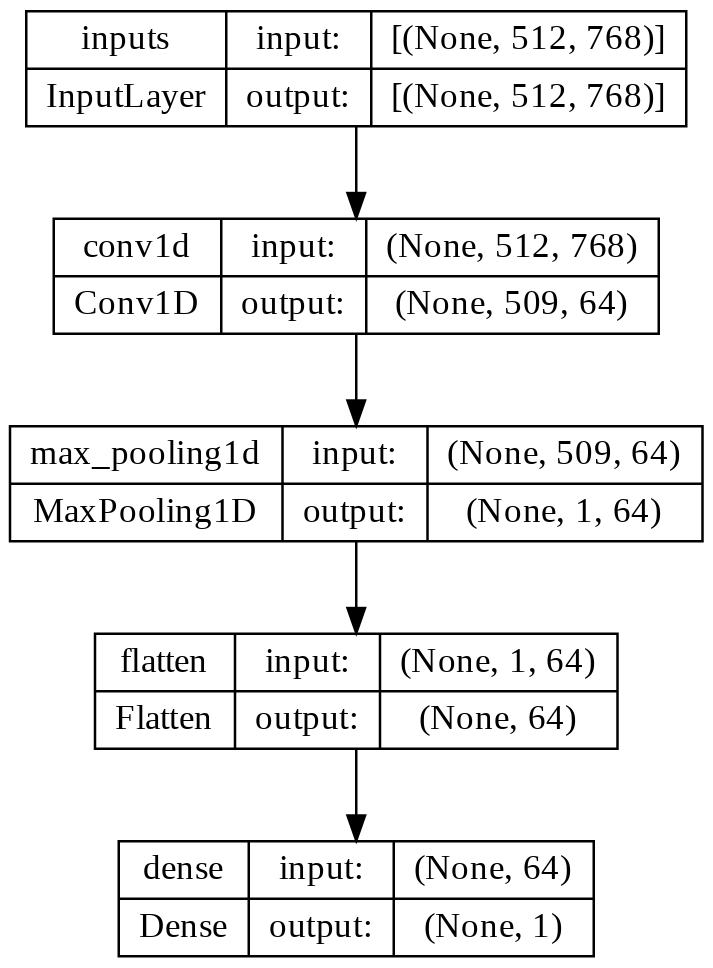

In [43]:
tf.keras.utils.plot_model( 
    embedding_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=180,
)

## Instrucciones de compilación

Estamos en el caso de una sola salida, ¿que pasaría si tomamos un problema de clasificación multiclase donde las clases serán los rangos salariales?

In [44]:
embedding_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [45]:
embedding_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 512, 768)]        0         
                                                                 
 conv1d (Conv1D)             (None, 509, 64)           196672    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 196,737
Trainable params: 196,737
Non-trainable params: 0
_____________________________________________________

In [46]:
embedding_model.fit(
    X_train_encajado, 
    y_train,
    #validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels), # Implementarlo a veces ayuda al modelo
    epochs=100,
    batch_size=53
)

Epoch 1/100
4/4 [==============================] - 3s 89ms/step - loss: 3439.0957 - mae: 57.1479
Epoch 2/100
4/4 [==============================] - 0s 46ms/step - loss: 1269.2434 - mae: 33.3515
Epoch 3/100
4/4 [==============================] - 0s 47ms/step - loss: 292.6693 - mae: 13.3551
Epoch 4/100
4/4 [==============================] - 0s 46ms/step - loss: 217.3889 - mae: 12.3743
Epoch 5/100
4/4 [==============================] - 0s 51ms/step - loss: 407.8842 - mae: 17.9723
Epoch 6/100
4/4 [==============================] - 0s 47ms/step - loss: 373.2520 - mae: 17.1793
Epoch 7/100
4/4 [==============================] - 0s 45ms/step - loss: 215.4966 - mae: 12.5395
Epoch 8/100
4/4 [==============================] - 0s 48ms/step - loss: 126.5457 - mae: 8.7478
Epoch 9/100
4/4 [==============================] - 0s 48ms/step - loss: 143.5933 - mae: 8.9525
Epoch 10/100
4/4 [==============================] - 0s 49ms/step - loss: 156.8503 - mae: 9.3402
Epoch 11/100
4/4 [======================

## Observación de resultados

In [47]:
y_pred = embedding_model.predict(encaje(X_test_tensor))

2/2 [==============================] - 0s 37ms/step


In [48]:
y_train_pred = embedding_model.predict(X_train_encajado)

7/7 [==============================] - 0s 24ms/step


## MSE

En datos de entrenamiento

In [49]:
((np.array(y_train) - y_train_pred.reshape(1,-1))**2/len(y_pred)).sum()

32.47121408571273

En datos de prueba

In [50]:
((np.array(y_test) - y_pred.reshape(1,-1))**2/len(y_pred)).sum()

145.45856611003697

## Ejemplos de la salida del modelo

In [51]:
y_train[:10]

179    58.0
115    72.0
96     68.0
233    60.0
60     72.0
16     53.0
55     62.0
148    70.0
196    87.0
228    59.0
Name: meanSalary, dtype: float64

In [52]:
y_train_pred[:10]

array([[59.09215 ],
       [79.0668  ],
       [68.332565],
       [60.901463],
       [61.28603 ],
       [53.23388 ],
       [68.02306 ],
       [70.06055 ],
       [86.98196 ],
       [61.56065 ]], dtype=float32)

In [53]:
y_test[:10]

248     67.0
215     59.0
194     85.0
168     59.0
66      71.0
137     70.0
175     59.0
260    102.0
9       54.0
114     66.0
Name: meanSalary, dtype: float64

In [54]:
y_pred[:10]

array([[65.39146 ],
       [69.83902 ],
       [67.98754 ],
       [67.633865],
       [64.875145],
       [64.209114],
       [66.58167 ],
       [76.623405],
       [60.912495],
       [67.92795 ]], dtype=float32)

# Ejercicio:

- Ejecutar el agoritmo pero ahora utilizar la columna de 'Job Title', ¿Qué notan?

# Enlaces de interes

- Tutorial a BERT: https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=Mq2PKplWfbFv